<a href="https://colab.research.google.com/github/tamisalvador/MSBA-Capstone-Individual-Notebook/blob/main/Tami_Individual_Notebook_Swire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Swire Coca-Cola Cart Abandonment


*Understanding cart abandonment at Swire Coca-cola*

Individual Notebook: Tami Salvador


## Table of Contents

1. [Business Problem](#business-problem)
2. [EDA](#EDA)
3. [Financial impact of abandoned carts](#financial-impact)

## Business Problem
Swire Coca-Cola’s digital ordering platform, MyCoke360, is experiencing significant cart abandonment, where customers add items to their carts but fail to complete purchases by their next order date. This behavior results in direct revenue loss, disrupts product mix performance, and risks long-term customer disengagement. Understanding the drivers of cart abandonment and recovery is critical to reducing revenue leakage, improving order completion, and strengthening customer retention. Insights from this analysis will identify behavioral patterns that influence cart abandonment and recovery and make recommendations to address these patterns.

## EDA

### Setup

Import libraries and read in data

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, precision_recall_curve

In [ ]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, precision_recall_curve


In [ ]:
# Import data
from google.colab import drive
drive.mount('/content/drive')

# Set the base path to folder
base_path = "/content/drive/MyDrive/Colab Notebooks/MSBA 8 Tables"

# Read all 8 tables
customer = pd.read_csv(f"{base_path}/customer.csv")
cutoff_times = pd.read_csv(f"{base_path}/cutoff_times.csv")
google_analytics = pd.read_csv(f"{base_path}/google_analytics.csv", low_memory=False)
material = pd.read_csv(f"{base_path}/material.csv")
operating_hours = pd.read_csv(f"{base_path}/operating_hours.csv")
orders = pd.read_csv(f"{base_path}/orders.csv")
sales = pd.read_csv(f"{base_path}/sales.csv")
visit_plan = pd.read_csv(f"{base_path}/visit_plan.csv", dtype=str)

Mounted at /content/drive


### EDA for operating_hours table


In [ ]:
# data types
display(operating_hours.head())
print(operating_hours.dtypes)

# summary statistics
display(operating_hours.describe(include='all').transpose())

# missing values
missing_operating = operating_hours.isnull().sum().sort_values(ascending=False)
display(missing_operating)

,CUSTOMER_NUMBER,FREQUENCY,DELIVERY_ANCHOR_DAY,CALLING_ANCHOR_DATE
0,600069597,Every 4 Weeks,Friday,2/5/2025
1,501562126,Every 4 Weeks,Tuesday,1/26/2025
2,500324496,Every 4 Weeks,Tuesday,2/2/2025
3,600259095,Every Week,Wednesday,2/4/2025
4,501072497,Every Week,Tuesday,11/17/2024


CUSTOMER_NUMBER         int64
FREQUENCY              object
DELIVERY_ANCHOR_DAY    object
CALLING_ANCHOR_DATE    object
dtype: object


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CUSTOMER_NUMBER,6202.0,NaN,NaN,NaN,524087601.484037,41608060.127333,500245685.0,501327579.0,501632551.5,501791136.75,600975318.0
FREQUENCY,6202,4,Every 4 Weeks,2562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DELIVERY_ANCHOR_DAY,6202,7,Wednesday,1343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CALLING_ANCHOR_DATE,6202,322,2/2/2025,177,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
CUSTOMER_NUMBER,0
FREQUENCY,0
DELIVERY_ANCHOR_DAY,0
CALLING_ANCHOR_DATE,0


In [ ]:
# Duplicate values
duplicates_operating = operating_hours.duplicated().sum()
print(f"Number of duplicate rows in operating_hours: {duplicates_operating}")

Number of duplicate rows in operating_hours: 0


Operating hours doesn't have any missing values.

In [ ]:
# Change date types
operating_hours['CALLING_ANCHOR_DATE'] = pd.to_datetime(
    operating_hours['CALLING_ANCHOR_DATE'],
    format='%m/%d/%Y',  # match your format like 2/5/2025
    errors='coerce'     # turns invalid formats into NaT instead of error
)

# Convert DELIVERY_ANCHOR_DAY to categorical
operating_hours['DELIVERY_ANCHOR_DAY'] = operating_hours['DELIVERY_ANCHOR_DAY'].astype('category')

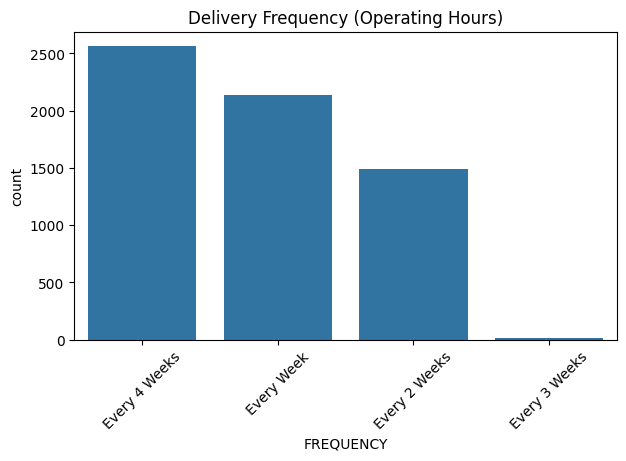

In [ ]:
# Operating Hours: frequency distribution
if "FREQUENCY" in operating_hours.columns:
    plt.figure(figsize=(7,4))
    sns.countplot(data=operating_hours, x="FREQUENCY", order=operating_hours["FREQUENCY"].value_counts().index)
    plt.title("Delivery Frequency (Operating Hours)")
    plt.xticks(rotation=45)
    plt.show()

### EDA for orders table

In [ ]:
# data types
display(orders.head())
print(orders.dtypes)

# summary statistics
display(orders.describe(include='all').transpose())

# missing values
missing_orders = orders.isnull().sum().sort_values(ascending=False)
display(missing_orders)

,CUSTOMER_ID,CREATED_DATE_EST,CREATED_DATE_UTC,MATERIAL_ID,ORDER_QUANTITY,ORDER_TYPE,PLANT_ID
0,600265510,2025-01-10,2025-01-10T22:40:25.000Z,152965.0,1.0,CALL CENTER,G267
1,600584506,2024-11-22,2024-11-22T17:34:30.000Z,156127.0,1.0,SALES REP,G221
2,600686120,2024-06-04,2024-06-05T00:29:33.000Z,103886.0,1.0,SALES REP,G291
3,501087671,2024-12-03,2024-12-03T18:14:23.000Z,134926.0,2.0,SALES REP,G163
4,501680332,2025-03-31,2025-03-31T22:33:07.000Z,152196.0,1.0,SALES REP,G221


CUSTOMER_ID           int64
CREATED_DATE_EST     object
CREATED_DATE_UTC     object
MATERIAL_ID         float64
ORDER_QUANTITY      float64
ORDER_TYPE           object
PLANT_ID             object
dtype: object


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CUSTOMER_ID,1662157.0,NaN,NaN,NaN,540226531.48514,48404450.399388,500245685.0,501240818.0,501621630.0,600080465.0,600975318.0
CREATED_DATE_EST,1662157,359,2025-05-15,17185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CREATED_DATE_UTC,1662157,112390,2024-08-05T19:28:03.000Z,205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MATERIAL_ID,1661962.0,NaN,NaN,NaN,168121.973103,96565.063993,100722.0,117803.0,137564.0,156090.0,700462.0
ORDER_QUANTITY,1662157.0,NaN,NaN,NaN,2.810771,12.937208,0.0,1.0,1.0,2.0,2000.0
ORDER_TYPE,1662157,6,SALES REP,1020574,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLANT_ID,1662146,44,G111,192987,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
MATERIAL_ID,195
PLANT_ID,11
CUSTOMER_ID,0
CREATED_DATE_UTC,0
CREATED_DATE_EST,0
ORDER_QUANTITY,0
ORDER_TYPE,0


In [ ]:
# Number of duplicate rows in orders
duplicates_orders = orders.duplicated().sum()
print(f"Number of duplicate rows in orders: {duplicates_orders}")

# Identify duplicate rows and count how many times each appears
duplicate_counts = orders.value_counts().reset_index(name='count')

# Filter only the rows that appear more than once
duplicate_counts = duplicate_counts[duplicate_counts['count'] > 1]

# Display a few examples
display(duplicate_counts.head(10))

Number of duplicate rows in orders: 847


,CUSTOMER_ID,CREATED_DATE_EST,CREATED_DATE_UTC,MATERIAL_ID,ORDER_QUANTITY,ORDER_TYPE,PLANT_ID,count
0,501543235,2024-07-21,2024-07-21T22:00:10.000Z,104631.0,2.0,MYCOKE360,G164,5
1,501029396,2024-06-04,2024-06-04T17:56:48.000Z,151695.0,1.0,OTHER,G291,5
2,501029396,2024-07-01,2024-07-01T18:58:52.000Z,151695.0,1.0,OTHER,G291,4
3,501543235,2024-07-21,2024-07-21T22:00:10.000Z,112259.0,1.0,MYCOKE360,G164,4
4,501543235,2024-07-21,2024-07-21T22:00:10.000Z,115304.0,1.0,MYCOKE360,G164,4
5,501029396,2024-10-24,2024-10-24T15:42:53.000Z,151695.0,1.0,OTHER,G291,4
6,501543235,2024-07-21,2024-07-21T22:00:10.000Z,117803.0,1.0,MYCOKE360,G164,4
7,501543235,2024-07-21,2024-07-21T22:00:10.000Z,138334.0,1.0,MYCOKE360,G164,4
8,501543235,2024-07-21,2024-07-21T22:00:10.000Z,138335.0,1.0,MYCOKE360,G164,4
9,501543235,2024-07-21,2024-07-21T22:00:10.000Z,138336.0,1.0,MYCOKE360,G164,4


In [ ]:
# Check for fully identical rows
exact_duplicates = orders[orders.duplicated(keep=False)]
print(f"Number of fully identical rows: {len(exact_duplicates)}")
display(exact_duplicates.head(10))


Number of fully identical rows: 0


,CUSTOMER_ID,CREATED_DATE_EST,CREATED_DATE_UTC,MATERIAL_ID,ORDER_QUANTITY,ORDER_TYPE,PLANT_ID


In [ ]:
# Drop duplicates
orders = orders.drop_duplicates(keep='first')
print(f"Remaining rows after dropping duplicates: {len(orders)}")

Remaining rows after dropping duplicates: 1661310


In the orders table, MATERIAL_ID has 195 missing values and PLANT_ID has 11. There are also 847 duplicate rows, that we will drop. it looks like the date time is already in UTC, so we don't need to modify this column.

In [ ]:
# fill missing values with 'missing'
orders['MATERIAL_ID'] = orders['MATERIAL_ID'].fillna('missing')
orders['PLANT_ID'] = orders['PLANT_ID'].fillna('missing')

# missing values
missing_orders = orders.isnull().sum().sort_values(ascending=False)
display(missing_orders)

,0
CUSTOMER_ID,0
CREATED_DATE_EST,0
CREATED_DATE_UTC,0
MATERIAL_ID,0
ORDER_QUANTITY,0
ORDER_TYPE,0
PLANT_ID,0
YearMonth,0


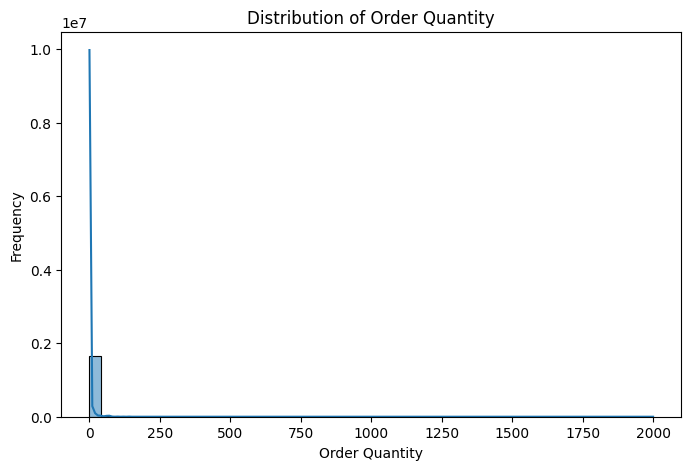

In [ ]:
# Orders: order quantity distribution
plt.figure(figsize=(8,5))
sns.histplot(orders["ORDER_QUANTITY"], bins=50, kde=True)
plt.title("Distribution of Order Quantity")
plt.xlabel("Order Quantity")
plt.ylabel("Frequency")
plt.show()

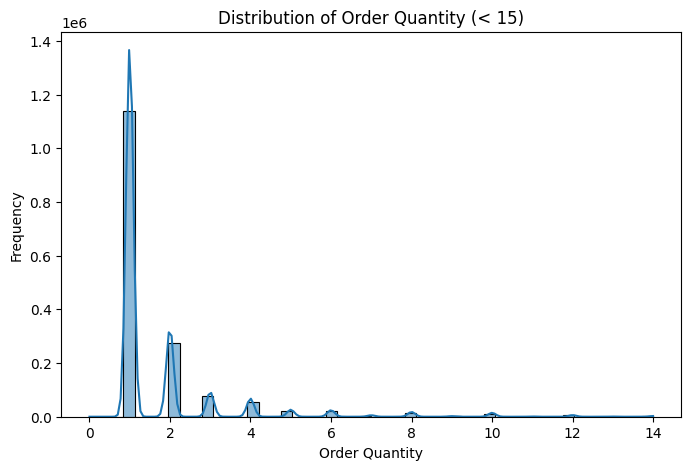

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(orders[orders["ORDER_QUANTITY"] < 15]["ORDER_QUANTITY"], bins=50, kde=True)
plt.title("Distribution of Order Quantity (< 15)")
plt.xlabel("Order Quantity")
plt.ylabel("Frequency")
plt.show()



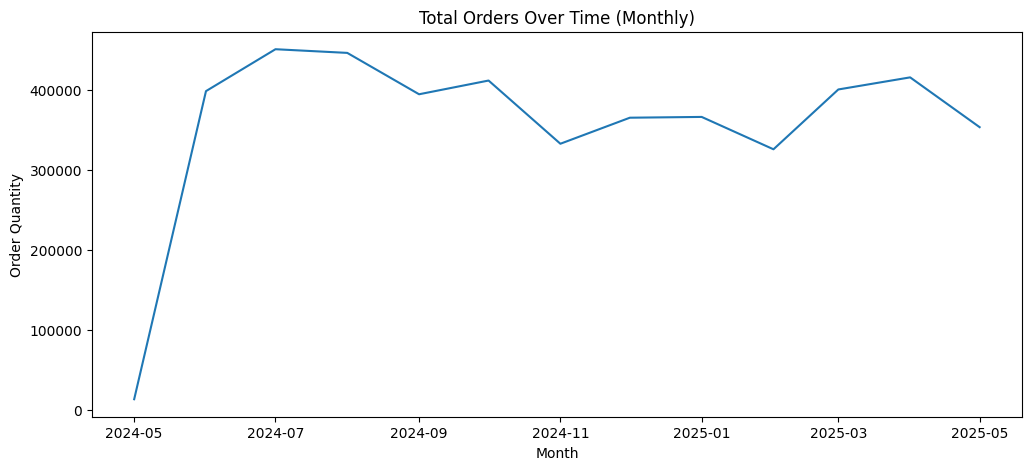

In [ ]:
# Orders: trend over time

orders['CREATED_DATE_EST'] = pd.to_datetime(orders['CREATED_DATE_EST'], errors='coerce')

# Create a Year-Month column
orders['YearMonth'] = orders['CREATED_DATE_EST'].dt.to_period('M')

# Group by month and sum order quantities
orders_by_month = orders.groupby('YearMonth')['ORDER_QUANTITY'].sum().reset_index()

# Convert YearMonth back to string or datetime for plotting
orders_by_month['YearMonth'] = orders_by_month['YearMonth'].dt.to_timestamp()

plt.figure(figsize=(12,5))
sns.lineplot(data=orders_by_month, x='YearMonth', y='ORDER_QUANTITY')
plt.title("Total Orders Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Order Quantity")
plt.show()

# Financial impact of abandoned carts

Now that we have defined abandoned and recovered carts, we will not analyze the financial impact of abandoned carts.

In [ ]:
# load the full_events_in_windows dataset
full_events_in_windows = pd.read_csv(f'{data_location}/full_events_in_windows.csv')

In [ ]:
# convert date colums to datetime with UTC
full_events_in_windows['window_start'] = pd.to_datetime(full_events_in_windows['window_start'], utc=True)
full_events_in_windows['window_end'] = pd.to_datetime(full_events_in_windows['window_end'], utc=True)

win_with_recovery['window_start'] = pd.to_datetime(win_with_recovery['window_start'], utc=True)
win_with_recovery['window_end'] = pd.to_datetime(win_with_recovery['window_end'], utc=True)


# join full_events_in_windows with win_with_recovery to get the Abandoned and Recovered flags
full_events_with_flags = pd.merge(
    full_events_in_windows,
    win_with_recovery[['CUSTOMER_ID', 'window_start', 'window_end', 'Abandoned', 'Recovered_before_next_window_end']],
    on=['CUSTOMER_ID', 'window_start', 'window_end'],
    how='left'
)

display(full_events_with_flags)

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS,window_start,window_end,Abandoned,Recovered_before_next_window_end
0,501508595,2025-04-07,2025-04-07 14:57:40.713000+00:00,view_search_results,mobile,Samsung,Android,Product List,NaN,[],2025-04-02 22:00:00+00:00,2025-04-09 22:00:00+00:00,0.0,0.0
1,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00,0.0,0.0
2,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00,0.0,0.0
3,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00,0.0,0.0
4,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4919465,501652046,2024-06-20,2024-06-20 16:41:32.073000+00:00,page_view,mobile,Apple,iOS,NaN,myWallet,[],2024-06-18 00:00:00+00:00,2024-07-02 00:00:00+00:00,NaN,NaN
4919466,501652046,2024-06-20,2024-06-20 16:41:32.073000+00:00,page_view,mobile,Apple,iOS,NaN,myWallet,[],2024-06-20 00:00:00+00:00,2024-07-04 00:00:00+00:00,NaN,NaN
4919467,501652046,2024-06-20,2024-06-20 16:41:32.073000+00:00,page_view,mobile,Apple,iOS,NaN,myWallet,[],2024-06-20 00:00:00+00:00,2024-07-04 00:00:00+00:00,NaN,NaN
4919468,600054564,2025-03-22,2025-03-22 21:31:57.667000+00:00,view_item_list,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,[],2025-03-20 00:00:00+00:00,2025-03-27 00:00:00+00:00,0.0,0.0


The data does not include a cart column, the following code will build a customer's cart based on their add to cart and remove from cart events.

In [ ]:
import json
from collections import defaultdict

def simulate_cart_and_get_abandoned_items(events_in_windows):
    """
    Simulates the cart state for each customer within each window
    and returns a DataFrame with abandoned items for windows with no purchase.
    """
    abandoned_items_list = []

    # group events by customer and window
    grouped_events = events_in_windows.sort_values('EVENT_TIMESTAMP').groupby(['CUSTOMER_ID', 'window_start', 'window_end'])

    for (customer_id, window_start, window_end), events in grouped_events:
        cart = defaultdict(int)
        had_purchase = False

        for _, event in events.iterrows():
            event_name = event['EVENT_NAME']
            items = event['ITEMS']

            if pd.notna(items):
                try:
                    items_list = json.loads(items)
                    for item in items_list:
                        item_id = item.get('item_id')
                        quantity = int(item.get('quantity', 0))

                        if item_id:
                            if event_name == 'add_to_cart':
                                cart[item_id] += quantity
                            elif event_name == 'remove_from_cart':
                                cart[item_id] = max(0, cart[item_id] - quantity) # ensure quantity doesn't go below zero
                            elif event_name == 'purchase':
                                had_purchase = True
                                cart = defaultdict(int) # reset cart on purchase
                                break

                except json.JSONDecodeError:
                    # handle cases where 'ITEMS' is not a valid JSON string
                    continue

        # after processing all events in the window, check if it was abandoned
        if not had_purchase and len(cart) > 0:
             # filter out items with zero quantity
            abandoned_items = {item_id: quantity for item_id, quantity in cart.items() if quantity > 0}
            if abandoned_items:
                abandoned_items_list.append({
                    'CUSTOMER_ID': customer_id,
                    'window_start': window_start,
                    'window_end': window_end,
                    'abandoned_items': abandoned_items
                })

    return pd.DataFrame(abandoned_items_list)

Let's apply the function to abandoned carts to get their items.

In [ ]:
# filter for abandoned windows
abandoned_events_with_flags = full_events_with_flags[full_events_with_flags['Abandoned'] == 1].copy()

# get abandoned items for the abandoned windows
abandoned_items_per_window = simulate_cart_and_get_abandoned_items(abandoned_events_with_flags)

display(abandoned_items_per_window)

,CUSTOMER_ID,window_start,window_end,abandoned_items
0,500245738,2024-11-08 21:30:00+00:00,2024-11-15 21:30:00+00:00,"{'157298': 1, '117854': 5, '117603': 5, '15608..."
1,500245738,2024-11-08 23:00:00+00:00,2024-11-15 23:00:00+00:00,"{'157298': 1, '117854': 5, '117603': 5, '15608..."
2,500245738,2025-01-30 00:00:00+00:00,2025-02-06 00:00:00+00:00,"{'158489': 1, '156082': 1, '151817': 3, '15329..."
3,500245738,2025-01-31 21:30:00+00:00,2025-02-07 21:30:00+00:00,"{'158489': 1, '156082': 1, '151817': 3, '15329..."
4,500245738,2025-01-31 23:00:00+00:00,2025-02-07 23:00:00+00:00,"{'158489': 1, '156082': 1, '151817': 3, '15329..."
...,...,...,...,...
4506,600866904,2024-11-08 00:00:00+00:00,2024-11-15 00:00:00+00:00,"{'103889': 2, '112259': 12, '103886': 2}"
4507,600866904,2024-11-12 00:00:00+00:00,2024-11-19 00:00:00+00:00,"{'103889': 2, '112259': 12, '103886': 2}"
4508,600975210,2024-11-13 22:30:00+00:00,2024-11-20 22:30:00+00:00,"{'412024': 1, '411040': 1, '110802': 1}"
4509,600975210,2025-02-26 22:30:00+00:00,2025-03-05 22:30:00+00:00,"{'145105': 1, '133129': 1, '103888': 1}"


Now that we have the items, we will attach a profit amount to each material id. Because there is no explicit profit per item column we will calculate one using the average profit per unit from the sales table.

In [ ]:
# calculate profit per unit
sales['profit_per_unit'] = sales['GROSS_PROFIT_DEAD_NET'] / sales['PHYSICAL_VOLUME']

# calculate the average profit per unit for each item
average_profit_per_item = sales.groupby('MATERIAL_ID')['profit_per_unit'].mean().reset_index()

# rename the column for clarity
average_profit_per_item = average_profit_per_item.rename(columns={'profit_per_unit': 'average_profit_per_unit'})

display(average_profit_per_item)

,MATERIAL_ID,average_profit_per_unit
0,100722,7.719879
1,100724,8.868830
2,101728,13.693392
3,101891,18.425048
4,101969,12.467675
...,...,...
956,700434,80.931068
957,700435,65.395000
958,700436,92.332857
959,700453,52.090000


In [ ]:
# join the sales and material tables on MATERIAL_ID
sales_with_material = sales.merge(material, on='MATERIAL_ID', how='left')

display(sales_with_material.head())

,CUSTOMER_ID,POSTING_DATE,MATERIAL_ID,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI_DEAD_NET,profit_per_unit,PACK_TYPE_DESC,TRADE_MARK_DESC,FLAVOUR_DESC,PACK_SIZE_DESC,BEV_CAT_DESC
0,600055574,7/17/2024,144775,130.68,22.0,737.00,5.940000,Aluminum Can,Bobby's Bottles,Matcha,16 OZ,ENERGY DRINKS
1,600055574,7/17/2024,156082,37.42,6.0,105.42,6.236667,Plastic Bottle - Other,Pete's Popcorn,Dragonfruit,20 OZ,ENHANCED WATER BEVERAGES
2,501438989,7/17/2024,144775,41.84,4.0,166.40,10.460000,Aluminum Can,Bobby's Bottles,Matcha,16 OZ,ENERGY DRINKS
3,600055574,7/17/2024,154914,53.24,4.0,123.88,13.310000,Plastic Bottle - Other,Sam's,Raspberry Lime,12 OZ,JUICES/NECTARS
4,600055574,7/17/2024,156182,110.30,10.0,348.80,11.030000,Plastic Bottle - Other,Fizz Factory,Grape,14 OZ,DAIRY/SOY BEVERAGES


Now that we have a financial value for each item, we can calculate the financial impact of items in abandoned carts.

In [ ]:
import json
from collections import defaultdict
import pandas as pd

# filter for abandoned windows
abandoned_events_with_flags = full_events_with_flags[full_events_with_flags['Abandoned'] == 1].copy()

# get items for abandoned carts
abandoned_items_per_window = simulate_cart_and_get_abandoned_items(abandoned_events_with_flags)


# expand the 'abandoned_items' dictionary into separate rows
expanded_data = []
for index, row in abandoned_items_per_window.iterrows():
    customer_id = row['CUSTOMER_ID']
    window_start = row['window_start']
    window_end = row['window_end']
    abandoned_items = row['abandoned_items']

    for item_id, quantity in abandoned_items.items():
        expanded_data.append({
            'CUSTOMER_ID': customer_id,
            'window_start': window_start,
            'window_end': window_end,
            'MATERIAL_ID': item_id,
            'abandoned_quantity': quantity
        })

abandoned_items_expanded = pd.DataFrame(expanded_data)

abandoned_items_expanded['MATERIAL_ID'] = pd.to_numeric(abandoned_items_expanded['MATERIAL_ID'], errors='coerce')

# drop rows where MATERIAL_ID is NaN after conversion
abandoned_items_expanded.dropna(subset=['MATERIAL_ID'], inplace=True)

# convert MATERIAL_ID in average_profit_per_item to int for merging
average_profit_per_item['MATERIAL_ID'] = average_profit_per_item['MATERIAL_ID'].astype(int)
abandoned_items_expanded['MATERIAL_ID'] = abandoned_items_expanded['MATERIAL_ID'].astype(int)

# convert MATERIAL_ID in material to int for merging
material['MATERIAL_ID'] = material['MATERIAL_ID'].astype(int)

# join with average profit per item to estimate potential loss per item instance
abandoned_items_with_profit = pd.merge(
    abandoned_items_expanded,
    average_profit_per_item,
    on='MATERIAL_ID',
    how='left'
)

# calculate potential financial loss per abandoned item instance
abandoned_items_with_profit['potential_financial_loss'] = (
    abandoned_items_with_profit['abandoned_quantity'] * abandoned_items_with_profit['average_profit_per_unit']
)

# join with material data for product mix analysis
abandoned_items_with_details = pd.merge(
    abandoned_items_with_profit,
    material,
    on='MATERIAL_ID',
    how='left'
)

In [ ]:
# calculate total estimated revenue lost from abandoned carts
total_estimated_loss = abandoned_items_with_details['potential_financial_loss'].sum()
print(f"Total estimated financial loss from abandoned carts: ${total_estimated_loss:,.2f}")

total_revenue = sales['GROSS_PROFIT_DEAD_NET'].sum()
print(f"\nTotal revenue from sales (Gross Profit): ${total_revenue:,.2f}")

# calculate percentage of estimated loss compared to total revenue
percentage_loss_of_revenue = (total_estimated_loss / total_revenue) * 100 if total_revenue > 0 else 0
print(f"\nEstimated financial loss as a percentage of total revenue (Gross Profit): {percentage_loss_of_revenue:.2f}%")

Total estimated financial loss from abandoned carts: $2,897,875.70

Total revenue from sales (Gross Profit): $35,613,850.43

Estimated financial loss as a percentage of total revenue (Gross Profit): 8.14%


In [ ]:
# analyze product mix of abandoned items by brand and pack type
abandoned_product_mix_brand = abandoned_items_with_details.groupby('TRADE_MARK_DESC')['potential_financial_loss'].sum().sort_values(ascending=False).reset_index()
abandoned_product_mix_pack_type = abandoned_items_with_details.groupby('PACK_TYPE_DESC')['potential_financial_loss'].sum().sort_values(ascending=False).reset_index()

print("\nEstimated financial loss from abandoned carts by Brand:")
abandoned_product_mix_brand['potential_financial_loss'] = abandoned_product_mix_brand['potential_financial_loss'].map('${:,.2f}'.format)
display(abandoned_product_mix_brand)

print("\nEstimated financial loss from abandoned carts by Pack Type:")
abandoned_product_mix_pack_type['potential_financial_loss'] = abandoned_product_mix_pack_type['potential_financial_loss'].map('${:,.2f}'.format)
display(abandoned_product_mix_pack_type)


Estimated financial loss from abandoned carts by Brand:


,TRADE_MARK_DESC,potential_financial_loss
0,Oliver Originals,"$1,113,502.28"
1,Fizz Factory,"$668,252.61"
2,Pete's Popcorn,"$251,367.00"
3,Jack's Juices,"$215,904.72"
4,Sam's,"$183,174.26"
5,Grandma's Pantry,"$125,544.09"
6,Blueberry Hill,"$92,776.37"
7,Lucy & Co.,"$74,511.31"
8,Billy's Lemonade,"$67,460.51"
9,Bobby's Bottles,"$41,561.71"



Estimated financial loss from abandoned carts by Pack Type:


,PACK_TYPE_DESC,potential_financial_loss
0,Plastic Bottle - Other,"$967,349.49"
1,Plastic Bottle - Contour,"$818,639.05"
2,Aluminum Can,"$514,852.07"
3,Bag-In-Box,"$222,131.20"
4,Plastic Bottle - Dimple,"$122,542.01"
5,Glass Bottle - Contour,"$97,973.24"
6,Aluminum Can - SLIIM,"$47,598.78"
7,CO2 Tank,"$40,308.54"
8,Glass Bottle - Other,"$25,315.58"
9,Paper Cup,"$20,188.10"


From our analysis, we see that abandoned carts account for almost $3 million in lost revenue. Being able to predict abandonment will be essential is recovering this lost revenue!

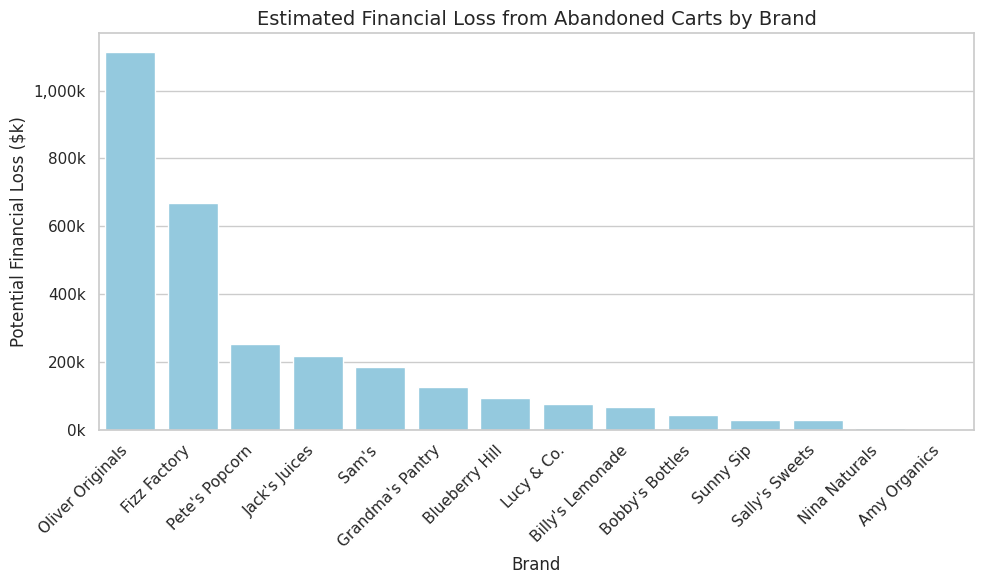

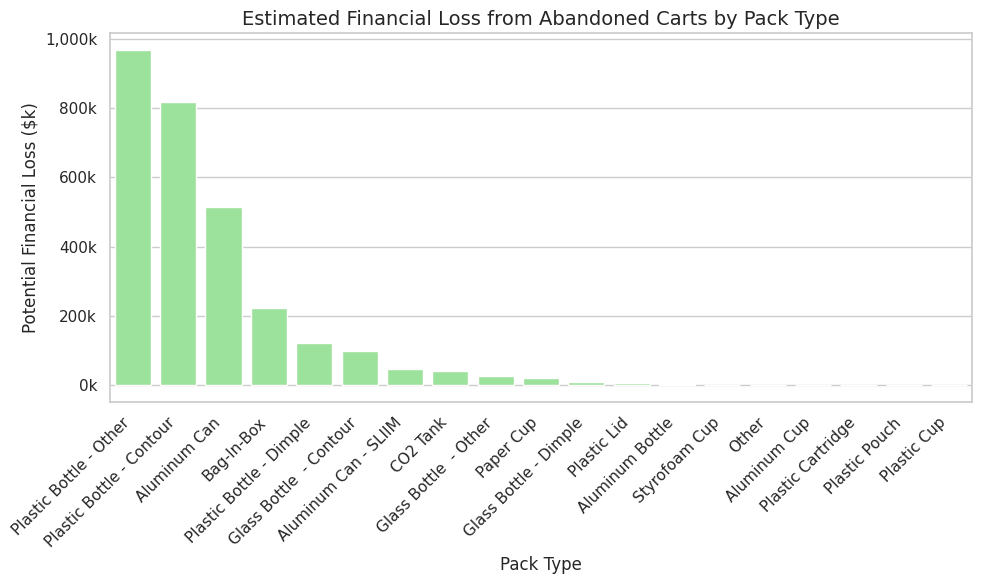

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Set style
sns.set(style="whitegrid")

# Bar chart: Financial loss by Brand
abandoned_product_mix_brand_plot = (
    abandoned_items_with_details.groupby('TRADE_MARK_DESC')['potential_financial_loss']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=abandoned_product_mix_brand_plot,
    x='TRADE_MARK_DESC',
    y='potential_financial_loss',
    color='skyblue',
    order=abandoned_product_mix_brand_plot['TRADE_MARK_DESC']  # preserve descending order
)
plt.title('Estimated Financial Loss from Abandoned Carts by Brand', fontsize=14)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Potential Financial Loss ($k)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Format y-axis in thousands
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000):,}k'))

plt.tight_layout()
plt.show()


# Bar chart: Financial loss by Pack Type
abandoned_product_mix_pack_type_plot = (
    abandoned_items_with_details.groupby('PACK_TYPE_DESC')['potential_financial_loss']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=abandoned_product_mix_pack_type_plot,
    x='PACK_TYPE_DESC',
    y='potential_financial_loss',
    color='lightgreen',
    order=abandoned_product_mix_pack_type_plot['PACK_TYPE_DESC']  # keep descending order
)
plt.title('Estimated Financial Loss from Abandoned Carts by Pack Type', fontsize=14)
plt.xlabel('Pack Type', fontsize=12)
plt.ylabel('Potential Financial Loss ($k)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Format y-axis in thousands
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000):,}k'))

plt.tight_layout()
plt.show()